In [1]:
from cv2 import resize
import numpy as np, matplotlib.pyplot as plt
import pickle
from house import House
import PIL
import os
import pandas as pd
PIL.Image.MAX_IMAGE_PIXELS = None



In [2]:

houses[0].__dict__.keys()

dict_keys(['utm_coords', 'utm_edges', 'utm_mean', 'image_ids', 'image_coords', 'image_edges', 'id'])

In [4]:
from cv2 import resize
import numpy as np, matplotlib.pyplot as plt
import pickle
from house import House
import PIL
import os
import pandas as pd
PIL.Image.MAX_IMAGE_PIXELS = None

with open('objects/camera_matrix1/houses.pickle', 'rb') as file:
    houses = pickle.load(file)
with open('objects/camera_matrix1/image_ids.pickle', 'rb') as file:
    image_ids = pickle.load(file)

ny, nx = 26460, 17004
header = ['ID', 'x', 'y', 'z', 'height2', 'rx', 'ry', 'rz',
          'pos1', 'pos2', 'pos3', 'att1', 'att2', 'att3', 'week', 'ToW', 'n_sat',
          'PDOP', 'lat', 'long', 'height']
metadata = pd.read_table(r'ims/aerial_photos/GNSSINS/EO_V355_TT-14525V_20210727_1.txt', comment='#', delim_whitespace=True, names=header)
metadata[['rx', 'ry', 'rz']] = metadata[['rx', 'ry', 'rz']].apply(np.deg2rad)
focal_length = int(100.5*1e-3/4e-6) # image coordinates
ppa = np.array((nx/2 - int(0.08*1e-3/4e-6), ny/2)) # image coordinatesaerial_photo = plt.imread(r'ims/aerial_photos/RGB/001.tif')
metadata = pd.read_table(r'ims/aerial_photos/GNSSINS/EO_V355_TT-14525V_20210727_1.txt', comment='#', delim_whitespace=True, names=header)
metadata[['rx', 'ry', 'rz']] = metadata[['rx', 'ry', 'rz']].apply(np.deg2rad)
focal_length = int(100.5*1e-3/4e-6) # image coordinates
ppa = np.array((nx/2 + int(0.08*1e-3/4e-6), ny/2)) # image coordinates

def make_data(ap_id, spent_ids, x_nudge=0, y_nudge=0, pad=15):
    aerial_photo = plt.imread(f'ims/aerial_photos/RGB/{(3 - len(str(ap_id)))*str(0) + str(ap_id)}.tif')
    with open('objects/camera_matrix1/houses.pickle', 'rb') as file:
        houses = pickle.load(file)
    dicts = []
    ims = []
    house_ids = []
    for i, house in enumerate(houses):
        if house.id in spent_ids:
            pass
        else:
            house_tr, edges_tr = house.image_coords[0], house.image_edges[0]
            ids = np.array(house.image_ids)
            
            if ap_id-1 in house.image_ids:            
                house_ids.append(house.id)
                ind = np.where(ids==ap_id-1)[0][0]
                house_tr = house_tr[ind]
                edges_tr = edges_tr[ind]
                xmin, ymin = np.min(house_tr, axis=1).astype(int) 
                xmax, ymax = np.max(house_tr, axis=1).astype(int)
                x_ext, y_ext = xmax-xmin, ymax-ymin
                if x_ext > y_ext:
                    sq_pad = np.array((0, (x_ext-y_ext)/2)).astype(int)
                else:
                    sq_pad = np.array(((y_ext-x_ext)/2, 0)).astype(int)


                
                im = aerial_photo[ymin-pad-sq_pad[1]:ymax+2*pad +sq_pad[1]+ y_nudge, xmin-pad - sq_pad[0]:xmax+2*pad + x_nudge+sq_pad[0]]
                x_ext, y_ext = im.shape[:2] 
                if x_ext != 0 and y_ext != 0:
                    house_tr[0] = (house_tr[0]-xmin+pad+x_nudge + sq_pad[0])*256/x_ext
                    house_tr[1] = (house_tr[1]-ymin+pad+y_nudge + sq_pad[1])*256/y_ext
                    
                    
                    d_min = np.min(im.shape[:2])
                    #ims.append(im[:d_min, :d_min])
                    ims.append(resize(im[:d_min, :d_min], (256, 256)))
                    out_dict = dict()
                    for j, edge in enumerate(edges_tr):
                        for k in range(edge.shape[1]):
                            edges_tr[j][0, k] += -xmin+pad+x_nudge + sq_pad[0]
                            edges_tr[j][1, k] += -ymin+pad+y_nudge + sq_pad[1]
                            edges_tr[j][0, k] *= 256/x_ext
                            edges_tr[j][1, k] *= 256/y_ext
                        out_dict[tuple(np.round(house_tr[:, j], 8))] = np.round(np.array(edge).swapaxes(1, 0), 8)
                    dicts.append(out_dict)
    return dicts, ims, house_ids

def viz(house, im, house_id, ax):
    ax.imshow(im)
    ax.set_title(house_id)
    for corner, edges in house.items():
        for edge in edges:
            ax.plot([corner[0], edge[0]], [corner[1], edge[1]], c='coral', zorder=0)
        ax.scatter(*corner, c='cornflowerblue', s=7, zorder=1)

def dump_ims(dicts, ims, house_ids,im_id):
    for i in range(len(dicts)):
        filename = str(house_ids[i])+'_'+str(im_id)
        np.save('test_output/temp/annot/'+filename,dicts[i])

        out_im = PIL.Image.fromarray(ims[i])
        out_im.save('test_output/temp/rgb/'+filename+'.jpg')

        fig, ax = plt.subplots( figsize=(7, 7))  
        viz(dicts[i], ims[i], house_ids[i], ax)
        fig.savefig('test_output/temp/viz/' + filename)  
        plt.close(fig) 

def RotationMatrix(rx, ry, rz):
    R1 = np.array([[1, 0, 0],
                   [0, np.cos(rx), -np.sin(rx)],
                   [0, np.sin(rx),np.cos(rx)]])
    
    R2 = np.array([[np.cos(ry), 0, np.sin(ry)],
                   [0, 1, 0],
                   [-np.sin(ry), 0, np.cos(ry)]])
    
    R3 = np.array([[np.cos(rz), -np.sin(rz), 0],
                   [np.sin(rz), np.cos(rz), 0],
                   [0, 0, 1]])
    
    return R1@R2@R3 

def UTM_to_image(X, C, x0, R, f):
    '''
    Calculates image coordinates using collinearity equations.

    X: Object positions in external coordinates. expects RGB dim as first shape dim, i.e. for N nodes, (3, N)
    C: Camera position in external coordinates
    x0: Focal point in image coordinates
    R: Perspective projection matrix from RotationMatrix()
    f: Focal length in image coordinates
    '''
    d = X-C.reshape(3, 1)
    denom = (R[0, 2]*d[0] + R[1, 2]*d[1] + R[2, 2]*d[2])
    img_coord = np.empty((2, X.shape[1]))
    img_coord[0] = x0[0] - f*(R[0, 0]*d[0] + R[1, 0]*d[1] + R[2, 0]*d[2])/denom
    img_coord[1] = ny - x0[1] + f*(R[0, 1]*d[0] + R[1, 1]*d[1] + R[2, 1]*d[2])/denom
    return img_coord

def Camera_matrix(image_id):
    cx, cy, cz, rx, ry, rz =  [metadata.loc[image_id][i] for i in ['x', 'y', 'z', 'rx', 'ry', 'rz']]
    R = RotationMatrix(rx, ry, rz) #camera rotation in w.r.t UTM
    C = np.array((cx, cy, cz)).reshape(-1, 1) #camera postion in UTM
    extrinsic_matrix = np.vstack([np.hstack([R.T, -R.T@C]),np.array((0, 0, 0, 1))])
    intrinsic_matrix = np.array(((focal_length, 0, ppa[0], 0),(0, focal_length, ppa[1], 0),(0, 0, 1, 0)))

    return intrinsic_matrix@extrinsic_matrix

def UTM_to_image2(utm_coords, image_id):
    '''
    Calculates image coordinates using the camera matrix.
    '''
    CM = Camera_matrix(image_id)
    utm_coords_hom = np.vstack([utm_coords, np.ones((1, utm_coords.shape[-1]))])
    im_coords = CM@utm_coords_hom
    im_coords = im_coords[:-1, :]/im_coords[-1]
    im_coords[0] = -im_coords[0] + nx 
    return im_coords

def transform_house(house):
    image_corners = list()
    image_edges = list()
    for id in house.image_ids:
        image_corners.append(UTM_to_image2(house.utm_coords, id))
        edge_ = list()
        for edge in house.utm_edges:
            edge_.append(UTM_to_image2(edge, id))
        image_edges.append(edge_)
    
    return image_corners, image_edges 

def make_data2(house, x_nudge=13, y_nudge=20, pad=15):

    dicts = []
    ims = []
    ap_ids = []
    for ind, ap_id in enumerate(house.image_ids):
        ap_ids.append(ap_id)
        print(ap_id, len(ap_ids))
        house_tr, edges_tr = house.image_coords[0], house.image_edges[0]
        aerial_photo = plt.imread(f'ims/aerial_photos/RGB/{(3 - len(str(ap_id+1)))*str(0) + str(ap_id+1)}.tif')
    

        house_tr = house_tr[ind]
        edges_tr = edges_tr[ind]
        xmin, ymin = np.min(house_tr, axis=1).astype(int) 
        xmax, ymax = np.max(house_tr, axis=1).astype(int)
        x_ext, y_ext = xmax-xmin, ymax-ymin
        if x_ext > y_ext:
            sq_pad = np.array((0, (x_ext-y_ext)/2)).astype(int)
        else:
            sq_pad = np.array(((y_ext-x_ext)/2, 0)).astype(int)


        
        im = aerial_photo[ymin-pad-sq_pad[1]:ymax+2*pad +sq_pad[1]+ y_nudge, xmin-pad - sq_pad[0]:xmax+2*pad + x_nudge+sq_pad[0]]
        x_ext, y_ext = im.shape[:2] 
        if x_ext != 0 and y_ext != 0:
            house_tr[0] = (house_tr[0]-xmin+pad+x_nudge + sq_pad[0])*256/x_ext
            house_tr[1] = (house_tr[1]-ymin+pad+y_nudge + sq_pad[1])*256/y_ext
            
            
            d_min = np.min(im.shape[:2])
            #ims.append(im[:d_min, :d_min])
            ims.append(resize(im[:d_min, :d_min], (256, 256)))
            out_dict = dict()
            for j, edge in enumerate(edges_tr):
                for k in range(edge.shape[1]):
                    edges_tr[j][0, k] += -xmin+pad+x_nudge + sq_pad[0]
                    edges_tr[j][1, k] += -ymin+pad+y_nudge + sq_pad[1]
                    edges_tr[j][0, k] *= 256/x_ext
                    edges_tr[j][1, k] *= 256/y_ext
                out_dict[tuple(np.round(house_tr[:, j], 8))] = np.round(np.array(edge).swapaxes(1, 0), 8)
            dicts.append(out_dict)
                        
    return dicts, ims, ap_ids

In [6]:
def viz(house, im, ax):
    ax.imshow(im)
    for corner, edges in house.items():
        for edge in edges:
            ax.plot([corner[0], edge[0]], [corner[1], edge[1]], c='coral', zorder=0)
        ax.scatter(*corner, c='cornflowerblue', s=7, zorder=1)

In [17]:
house_id = 37780
for i, house in enumerate(houses):
    if house.id==house_id:
        print(i)


2115


In [18]:
house  = houses[2115]
dicts, ims, im_ids = make_data2(house)
print(len(dicts))

85 1
86 2
87 3
88 4
89 5
111 6
112 7
113 8
114 9
115 10
10


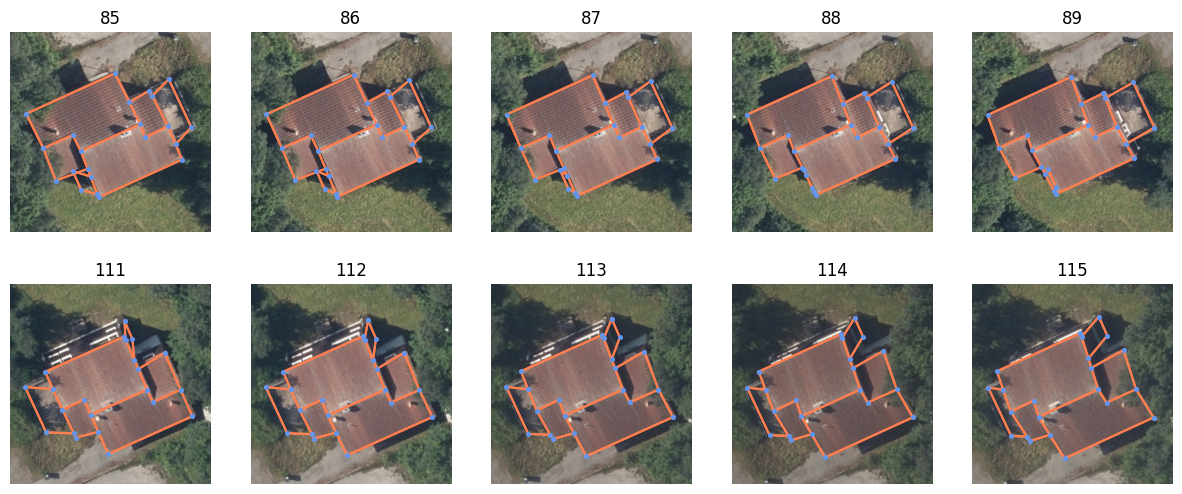

In [19]:
if len(dicts)==5:
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))    
else:
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    
for i, ax in enumerate(axs.flatten()):
    ax.axis('off')
    ax.set_title(im_ids[i])
    viz(dicts[i], ims[i], ax)

In [16]:
path = 'test_output/reproject_set/{}'.format(house_id)
os.mkdir(path)
with open(path + '/house.pickle', 'wb') as file:
    pickle.dump(house, file)

for i in range(len(dicts)):
    filename = str(im_ids[i])

    out_im = PIL.Image.fromarray(ims[i])
    out_im.save(path + '/{}.jpg'.format(filename))
 

In [11]:
with open(r'testing/objects/houses.pickle', 'wb') as file:
    pickle.dump(houses, file)

FileNotFoundError: [Errno 2] No such file or directory: 'testing/objects/houses.pickle'